# IRIS Dataset Exploration and Visualization using KNN with PCA and LDA

In [213]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, lda
from sklearn.learning_curve import learning_curve
import sklearn
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier


## Load Data

In [214]:
#Load in the IRIS Dataset
iris = pd.read_csv("iris.data", header = -1)
irism = iris.as_matrix()
#Randomize the index
rindex = sklearn.utils.shuffle(range(0,len(irism)))
#randomize inditial matrix
matrix = irism[rindex,:]
irism = matrix

In [215]:
#Split test and train matrix
trainint, testint = cross_validation.train_test_split(irism, test_size=0.33, random_state=1)

xtrain = trainint[:,:4]
ytrain = trainint[:,4]
xtest = testint[:,:4]
ytest = testint[:,4]

le = preprocessing.LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.transform(ytest)

#Scale predictors for Xs on test and train
scaler = sklearn.preprocessing.StandardScaler()
scalefit = scaler.fit(xtrain)
scale_xtrain = scaler.transform(xtrain)
scale_xtest = scaler.transform(xtest)

#Create total scaled matrix for easier access
total_scale_x  = np.ma.row_stack((xtrain,xtest))
total_scale_y = np.concatenate((ytrain,ytest))

##LDA
lda = sklearn.lda.LDA(solver = "eigen")
#Fit LDA on training set
fit = lda.fit(scale_xtrain,ytrain)
#Convert entire dataset to LDA Dimensions
lda_scores = lda.transform(total_scale_x)
ldatrain = lda.transform(trainint[:,0:4])
ldatest = lda.transform(testint[:,0:4])


#{PCA}
pca = PCA(n_components=4)
fit = pca.fit(scale_xtest)
pca_scores = pca.transform(total_scale_x)
pcatrain = pca.transform(trainint[:,0:4])
pcatest = pca.transform(testint[:,0:4])



In [216]:
#Save the files for plotting in R
numpy.savetxt("pca_scores.csv", pca_scores, delimiter=",")
numpy.savetxt("lda_scores.csv", lda_scores, delimiter=",")
numpy.savetxt("total_scale_y.csv", total_scale_y, delimiter=",")

## Data Visualization with PCA and LDA

The Plotter  function is for determining if more data points will help improve performance of KNN

In [217]:
%matplotlib inline

def plotter(train_scores,test_scores,train_sizes):
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Testing score")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title('Training Curves')
    plt.show()

The KNN Plotter uses a KNN estimator and a dataset to create visual KNN plots

In [218]:
def KNNPlotter(estimator,Xtrain,Ytrain,Xtest,Ytest,n_neighbors,weights):
    X = Xtrain
    y = ytrain
    h = 0.02
    KNN = estimator
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    cmap_tests = ListedColormap(['#FF0000', '#04B404', '#0000FF'])
    KNN.set_params(n_neighbors = n_neighbors)
    KNN.fit(X,y)
    # we create an instance of Neighbours Classifier and fit the data.
    train_percent = KNN.score(X, y)


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #Creates set of grid numbers for xmin and xmax(from the dataset) and uses stepH to get the numbers
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    #Sends all of those numbers into a prediction
    #Unravles matrix into an array
    Z = KNN.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    #Uses xx and yy as the plotting points with Z as the prediction values and applies a color mapping
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)

    #Plot test points
    y2out = KNN.score(Xtest,Ytest)
    #y2labels = le.fit_transform(Ytest)
    plt.scatter(Xtest[:,0], Xtest[:, 1], c=Ytest, cmap=cmap_tests, marker = "x")

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s'\ntrain percent = %.2f test percent = %.2f)"
              % (n_neighbors, weights,train_percent,y2out))
    #plt.show()

The following 3D Plot was created using R

We can see from the 3D plots that there is some interesting splitting that occurs with PCA and LDA. The LDA seems to have tighter grouped components for Setosa. Both however seem to have some difficulty for Veriscolor and Virginica.

Going forward we will be using only 2 dimensions of the PCA. By rotating the graphs it is a reasonable guess that LDA might perform better because of the potential splits we can see in a 2D plane using the first 2 principal components (V1 and V2).

## Complete KNN - Using all possible predictor values

In [219]:
KNN = sklearn.neighbors.KNeighborsClassifier()
KNN.fit(scale_xtrain,ytrain)
trainlist = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
train_sizes, train_scores, test_scores = learning_curve(KNN, total_scale_x, total_scale_y, train_sizes = trainlist, cv = 5)

In [220]:
scores = cross_validation.cross_val_score(KNN,total_scale_x, total_scale_y, cv = 5, scoring = "accuracy")
mean(scores)

0.96666666666666679

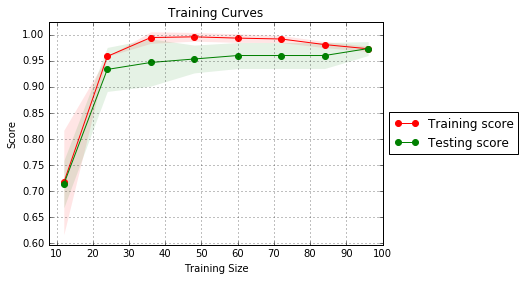

In [221]:
plotter(train_scores,test_scores,train_sizes);

The plot uses ALL dimensions to predict KNN. We can see that it does quite well with a fairly large amount of training samples. Here we test up to 80% of the full training set. We can see that additional datapoints will most likely not help improve KNN

This plot makes sense that the training score almost always does better than the testing score. We are fitting the data to our training and expect it to do better.

## KNN Classification using Principal Component Analysis

In [222]:
KNN = sklearn.neighbors.KNeighborsClassifier()
scores = cross_validation.cross_val_score(KNN,pca_scores[:,0:2], total_scale_y, cv = 5, scoring = "accuracy")
mean(scores)

0.94666666666666666

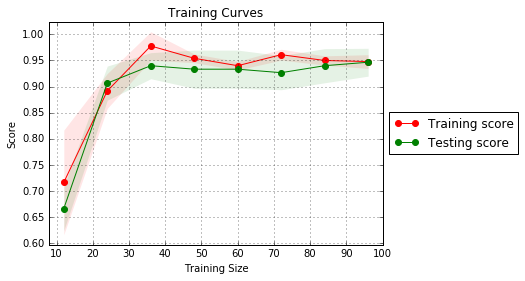

In [223]:
trainlist = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
train_sizes, train_scores, test_scores = learning_curve(KNN, pca_scores[:,0:2], total_scale_y, train_sizes = trainlist, cv=5)
plotter(train_scores,test_scores,train_sizes)

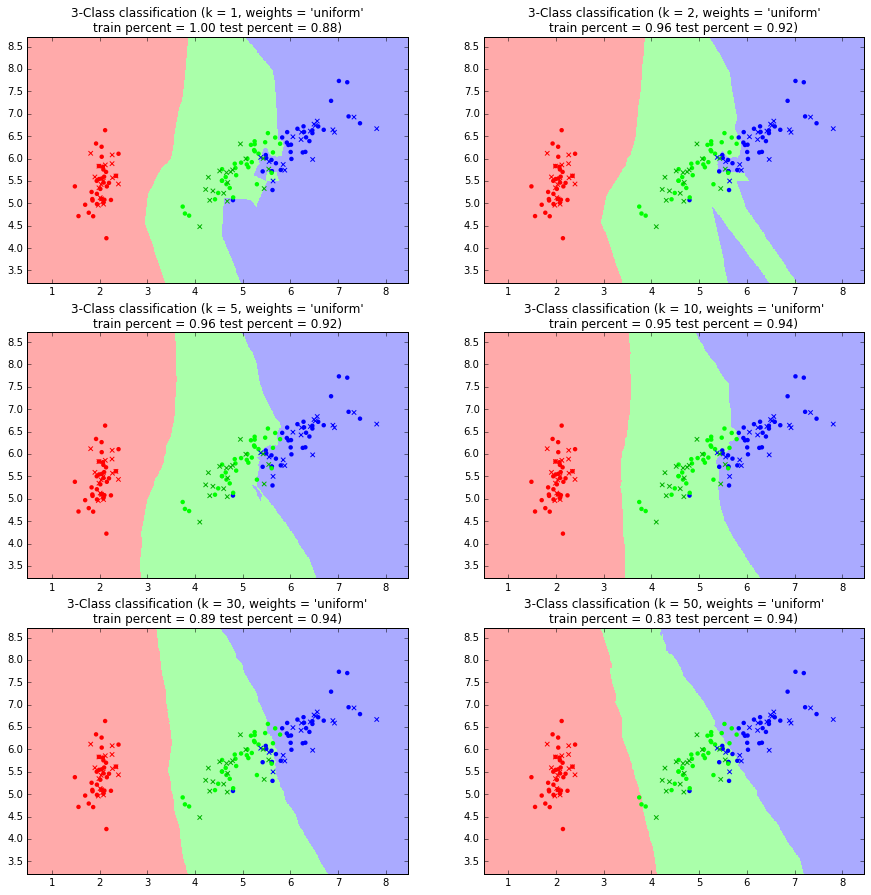

In [224]:
f, axs = plt.subplots(3,2,figsize=(15,15))
k = [1,2,5,10,30,50]
for i in range(1,7):
    subplot(320 + i)
    KNNPlotter(KNN,pcatrain[:,0:2],ytrain,pcatest[:,0:2],ytest,k[i-1],"uniform")

## KNN Classification using Linear Discriminant Analysis

In [225]:
KNN = sklearn.neighbors.KNeighborsClassifier()
scores = cross_validation.cross_val_score(KNN,lda_scores[:,0:2], total_scale_y, cv = 5, scoring = "accuracy")
mean(scores)

0.96000000000000019

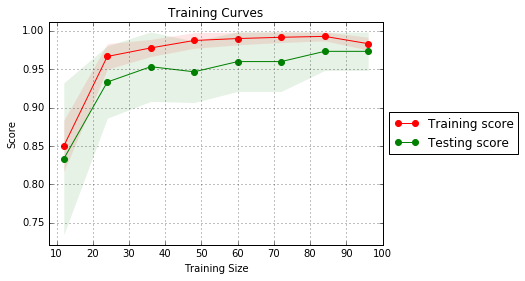

In [226]:
KNN = sklearn.neighbors.KNeighborsClassifier()
trainlist = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
train_sizes, train_scores, test_scores = learning_curve(KNN, lda_scores, total_scale_y, train_sizes = trainlist, cv=5)

plotter(train_scores,test_scores,train_sizes)

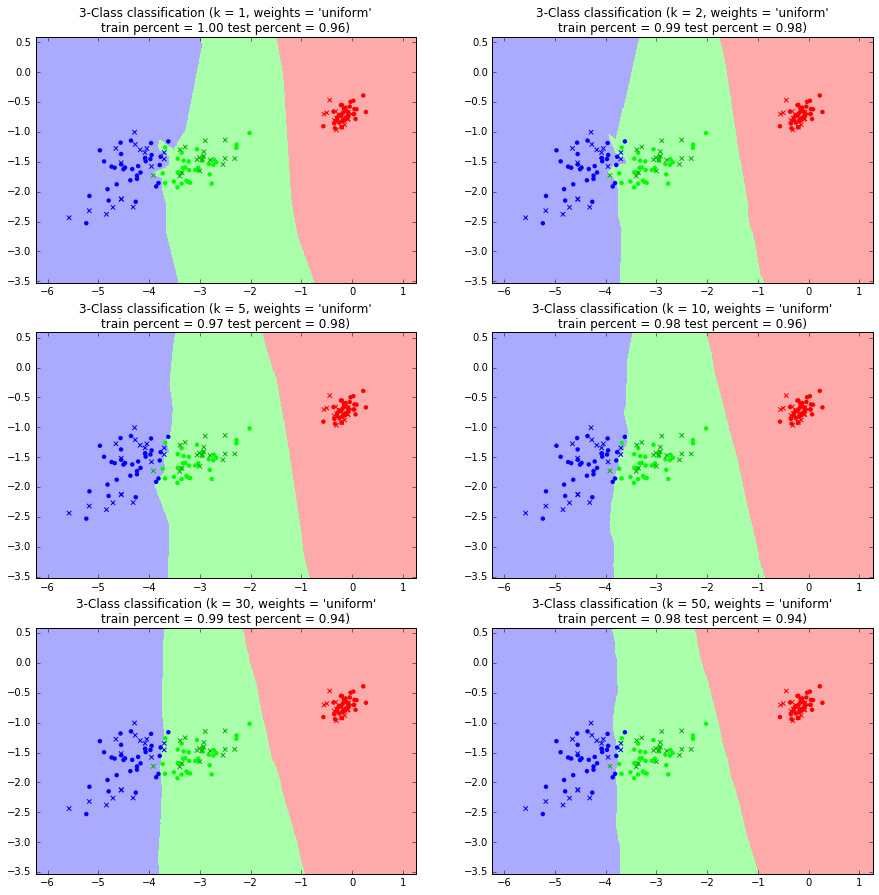

In [227]:
f, axs = plt.subplots(3,2,figsize=(15,15))
k = [1,2,5,10,30,50]
for i in range(1,7):
    subplot(320 + i)
    KNNPlotter(KNN,ldatrain[:,0:2],ytrain,ldatest[:,0:2],ytest,k[i-1],"uniform")
    

We can see that these plots are different than PCA in that they are more tightly grouped. We can also see that the performance has improved which is most likely due to our assumption of normality.

This is particularly interesting becuase we are able to get comparable results to the complete KNN while only using 2 dimensions with PCA/LDA.

Performance Summary:   
KNN : 0.97333333333333338   
PCA KNN : 0.93333333333333324   
LDA KNN : 0.96666666666666679